In [23]:
%matplotlib inline

import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import csv
import io as io
import os as os

In [49]:
experimentDir = "plotData/timeout_estimation_sa_2019-02-09_00-42-50"

allData = {}

for solverName in os.listdir(experimentDir):
    allData[solverName] = {}
    dimensions = os.listdir(experimentDir + "/" + solverName)
    for dimensionDir in sorted(dimensions):
        dimension = int(dimensionDir[2:])
        exData = allData[solverName][dimension] = {}
        exData["runs"] = []
        runDir = experimentDir+"/"+solverName+"/"+dimensionDir+"/"
        for runData in os.listdir(runDir):
            runDataPath = runDir + "/" + runData
            if runData.startswith("run"):
                table = pd.read_csv(runDataPath, names=["runtime","cntProbe","merit"], sep="\s+", header=None)
                exData["runs"].append(table) 
     #       else:
      ##          table = pd.read_csv(runDataPath, usecols=["timeout hitsN hitRatio avgT"], header=None)
        #        exData["summary"] = table

In [140]:
concreteRun = allData["sa"][23]
sampleRun = concreteRun["runs"][0]

0.9088800386684918
0.010987617846735265
0.9852852212513001


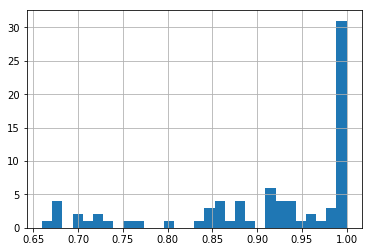

In [116]:
# Sample correlation

corrTable = pd.DataFrame()
for table in concreteRun["runs"]:
    corrVal = table["runtime"].corr(sampleRun["cntProbe"])
    corrTable = corrTable.append({"corr": corrVal}, ignore_index = True)

print(corrTable["corr"].mean())
print(corrTable["corr"].var())
print(corrTable["corr"].quantile(q=0.6))
corrTable["corr"].hist(bins=30)

In [139]:
# Average correlation over one run

corrTable = pd.DataFrame()
for n, data in allData["sa"].items():
    for table in data["runs"]:
        corrVal = table["runtime"].corr(sampleRun["cntProbe"])
        corrTable = corrTable.append({n: corrVal}, ignore_index = True)

resTable = pd.DataFrame()
for n in corrTable:   
    resTable = resTable.append({ "n": n
                      , "mean": corrTable[n].mean()
                      , "var": corrTable[n].var()
                      , "q05": corrTable[n].quantile(q=0.5)
                      , "q075": corrTable[n].quantile(q=0.75)
                      , "q095": corrTable[n].quantile(q=0.95)}, ignore_index = True)

aggTable = resTable.drop(columns=["n"]).agg(["mean"])
display(aggTable)

,mean,q05,q075,q095,var
mean,0.890416,0.918796,0.973338,0.997005,0.010131
